#Задание
1. Применить метод K ближайших соседей (ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification;

2. Найти датасет с картинками.
Построить embedding изображений. Применить метод без оптимизации knn для полученного датасета из векторизованных картинок;

3. Сделать свои фотографии (2-3) и повторить пункт 4 с ними.

In [29]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

#Задание №1
Применить метод K ближайших соседей (ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification.

In [30]:
# Создаём датасет
X, Y = make_classification(n_samples=500, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=0)
     

In [31]:
# Настройки для одного графика и вывод
def plot_3d_results(X_test, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for idx in range(len(X_test)):
        point = X_test[idx]
        color = ''
        if predictions[idx] == 0:
            color = '#ff7f0e'
        elif predictions[idx] == 1:
            color = '#2ca02c'
        elif predictions[idx] == 2:
            color = '#d62728'
        elif predictions[idx] == 3:
            color = '#9467bd'
        elif predictions[idx] == 4:
            color = '#8c564b'

        ax.scatter(point[0], point[1], point[2], c = color)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

In [32]:
# Вывод графиков
def Print(models):
  for i in range(5, 10):
      predictions = models[i].predict(X_test)
      plot_3d_results(X_test, predictions)

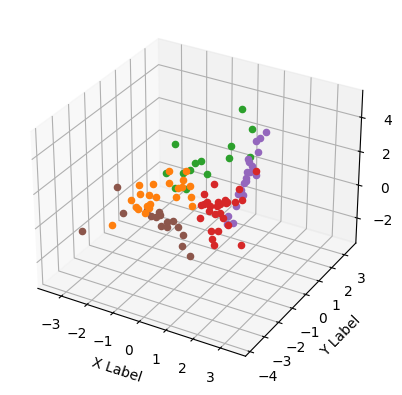

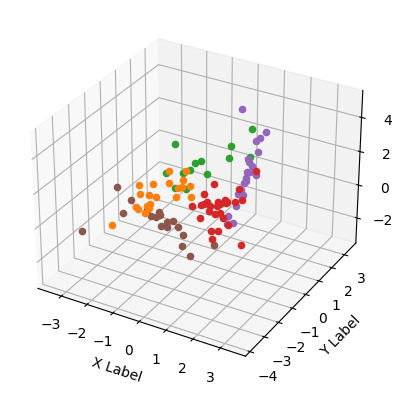

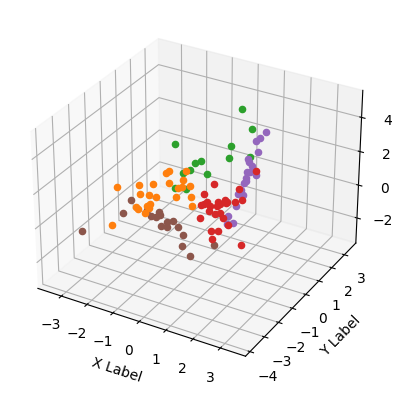

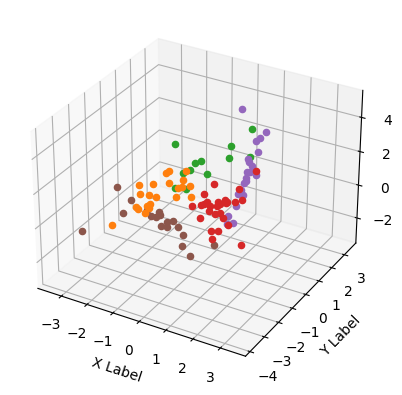

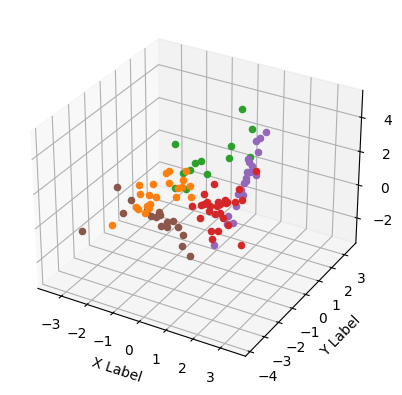

In [33]:
# Метод k-ближайших соседей
models = []
for n_neighbor in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=n_neighbor)
    model.fit(X_train, Y_train)
    models.append(model)

Print(models)

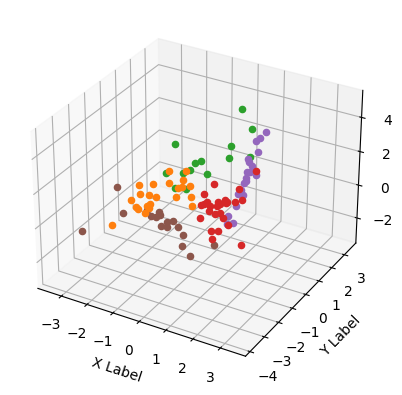

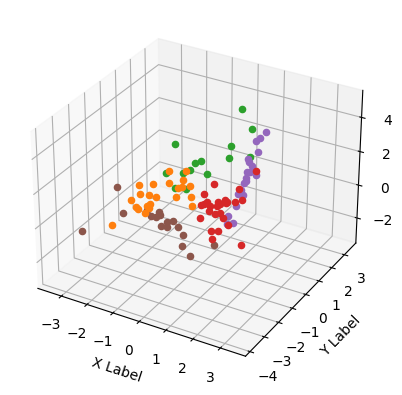

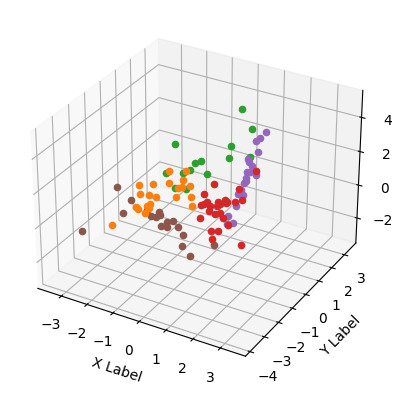

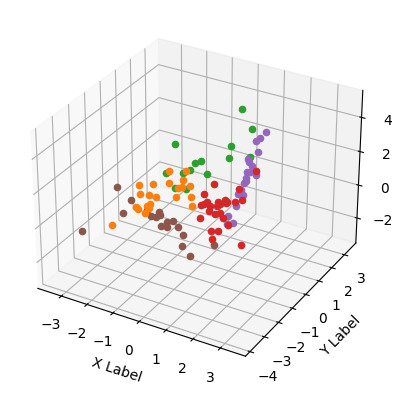

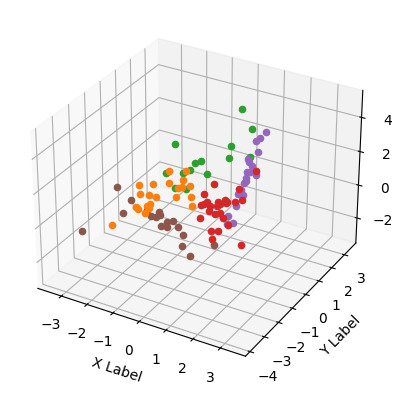

In [34]:
# Метод k-ближайших взвешенных соседей
def func(distance):
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

models = []
for n_neighbors in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=func)
    model.fit(X_train, Y_train)
    models.append(model)

Print(models)

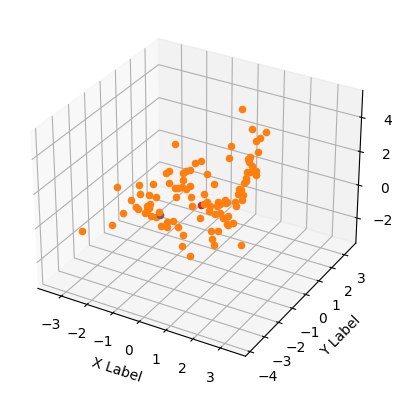

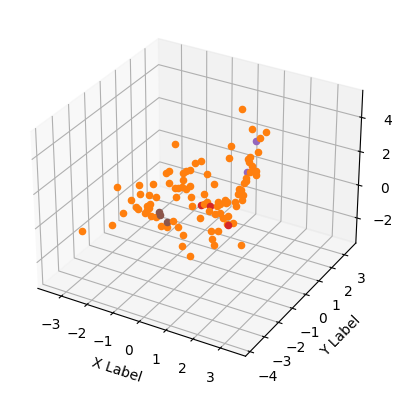

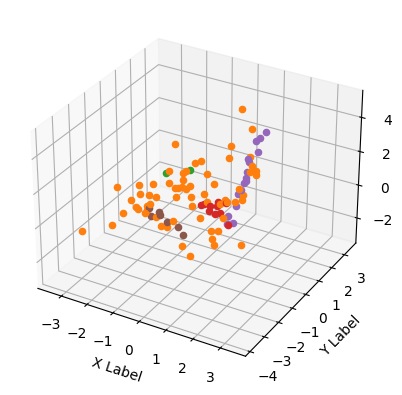

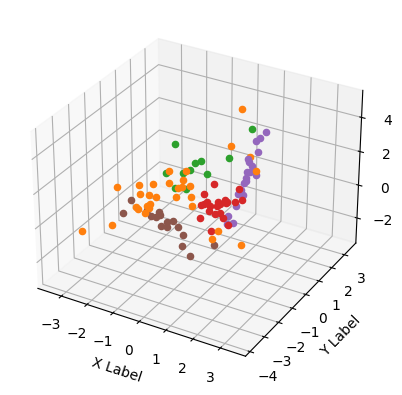

In [35]:
# Ядерный метод
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = KNeighborsClassifier(n_neighbors=len(X_train), weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    plot_3d_results(X_test, predictions)

#Задание №2 
Построить embedding изображений. Применить метод без оптимизации KNN для полученного датасета из векторизованных картинок

In [36]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import numpy as np
from ast import literal_eval
from sklearn.manifold import TSNE

In [37]:
test_data = pd.read_csv('./fashionmnist/fashion-mnist_train.csv', header = None)

<ipython-input-37-661565a4dd3d>:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

In [85]:
labels = test_data.iloc[1:, 0]
images = test_data.iloc[1:, 1:]

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
         'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [86]:
X_train, X_dev, y_train, y_dev = train_test_split(images, labels, test_size=0.01)

X_train_standardized = StandardScaler().fit_transform(X_train)
X_dev_standardized = StandardScaler().fit_transform(X_dev)

X_train_normalized = Normalizer().fit_transform(X_train_standardized)
X_dev_normalized = Normalizer().fit_transform(X_dev_standardized)

<ipython-input-88-a235c13be99c>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(X_dev.values.astype(np.int)[num].reshape(28,28), cmap=plt.cm.binary)


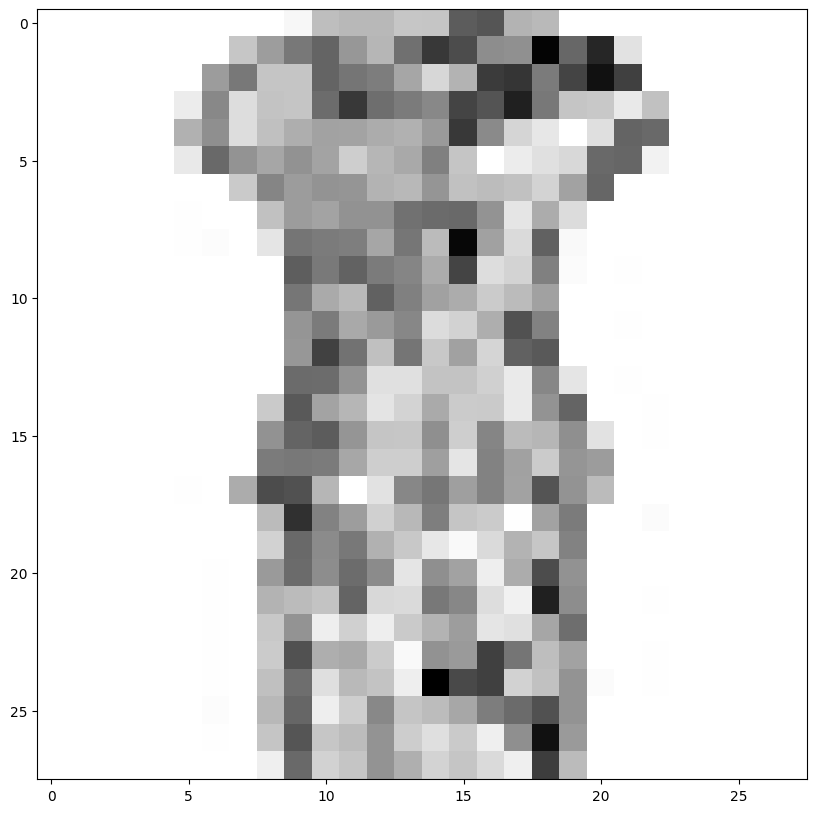

In [88]:
X_dev_tsne = TSNE(n_components=2).fit_transform(X_dev_normalized)
num = 10 
plt.imshow(X_dev.values.astype(np.int)[num].reshape(28,28), cmap=plt.cm.binary)

<ipython-input-89-d933dce4caec>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for k, i in enumerate(np.unique(y.astype(np.int))):


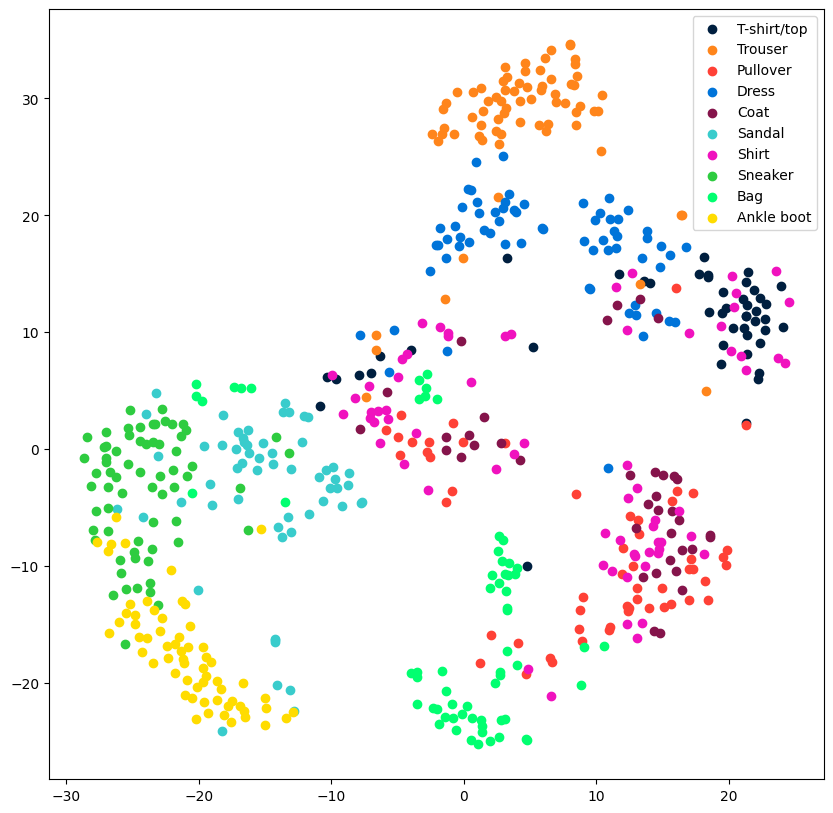

In [89]:
colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']

def plot_embedding_v1(X_embeded, y):
    plt.rcParams["figure.figsize"] = [10,10]
    for k, i in enumerate(np.unique(y.astype(np.int))):
        plt.scatter(X_embeded[y == i, 0],
                   X_embeded[y == i, 1],
                   color = '#%02x%02x%02x' % literal_eval(colors[k][3:]), 
                    label = label_names[k])
    plt.legend()
    plt.show()

plot_embedding_v1(X_dev_tsne, y_dev)

In [90]:
y_dev_array=y_dev.iloc[0:].values.astype('int')
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_dev_tsne, y_dev_array)

KNeighborsClassifier(n_neighbors=1)

#Задание №3
Повторить пункт №2 с своими фотографиями.

In [91]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import io



def check(img_path, img_small):
  img = io.imread(img_small)
  imgGray = color.rgb2gray(img)
  imgGray_standardized = StandardScaler().fit_transform(imgGray)
  imgGray_normalized = Normalizer().fit_transform(imgGray_standardized)
  imgGray_tsne = TSNE(n_components=2, perplexity=26).fit_transform(imgGray_normalized)
  print(imgGray_tsne)
  output = model.predict(imgGray_tsne)

  plt.imshow(mpimg.imread(img_path))
  plt.title(f"The prediction for image being identified as: {output} - {label_names[output[2]]}.")
  plt.show()

[[ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [  77.38958     44.858543 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 122.77953     40.62061  ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 122.77953     40.62061  ]
 [ 128.62392     28.193295 ]
 [ 103.75185     21.722292 ]
 [ 103.75185     21.722292 ]
 [ 103.75185  

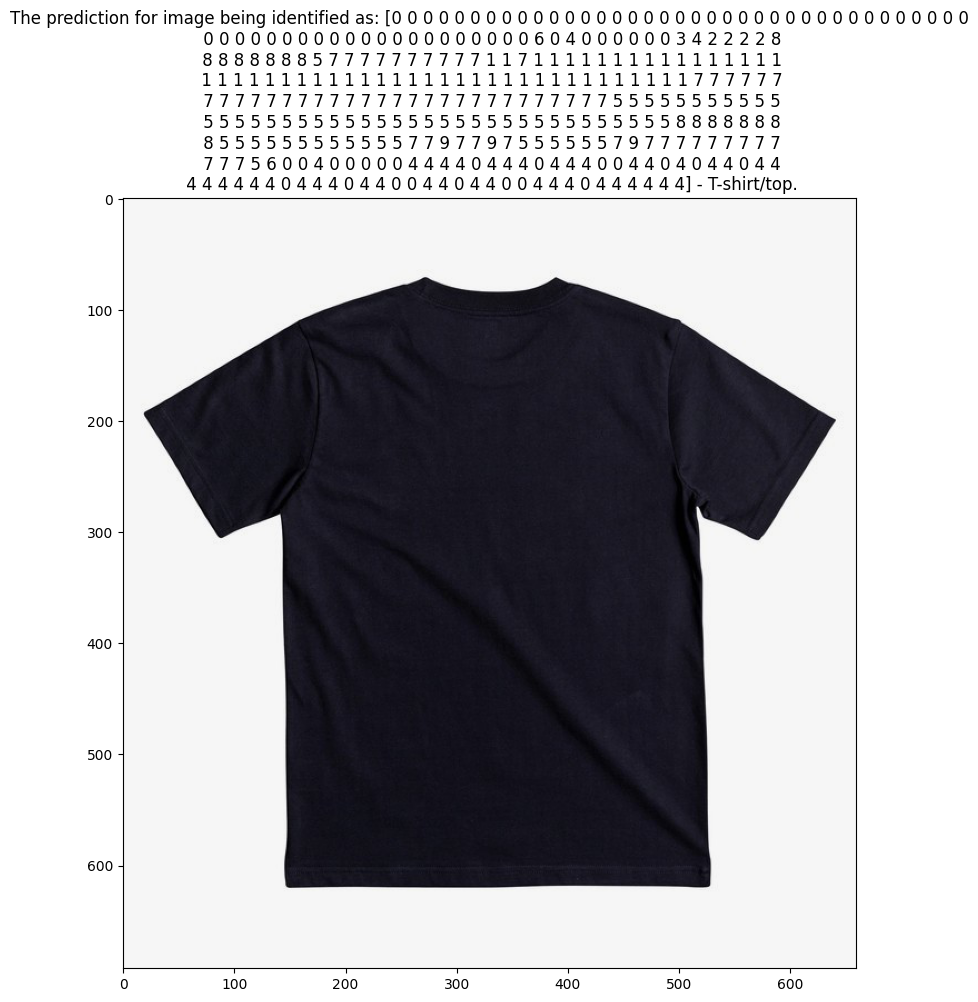

In [70]:
check("/content/t-shirt.jpg", "/content/t-shirt1.jpg")

[[ 25.914902    -5.236768  ]
 [ 23.867748     1.3783003 ]
 [ 23.602583     0.30193487]
 [ 23.29952      4.3065934 ]
 [ 23.283583     4.32531   ]
 [ 23.867748     1.3783003 ]
 [ 23.602583     0.30193487]
 [ 25.914902    -5.236768  ]
 [ 22.600853    -1.1241189 ]
 [ 22.600853    -1.1241189 ]
 [ 22.600853    -1.1241189 ]
 [ 23.867748     1.3783003 ]
 [ 23.867748     1.3783003 ]
 [ 25.000212     2.738902  ]
 [ 25.000212     2.738902  ]
 [ 25.000212     2.738902  ]
 [ 26.633986    -5.2067075 ]
 [ 27.033735    -4.7885613 ]
 [ 26.67987     -4.936694  ]
 [ 23.21283      0.7758789 ]
 [ 23.029985     0.23755379]
 [ 22.699104     4.3715506 ]
 [ 21.675966     4.136973  ]
 [ 20.689152     3.7167137 ]
 [ 19.530556     3.2906032 ]
 [ 19.276077     3.2708368 ]
 [ 15.67174      4.3946805 ]
 [ 15.397238     4.4809413 ]
 [ 14.945377     4.621447  ]
 [ 14.391884     4.7901874 ]
 [ 13.812086     4.9603367 ]
 [ 13.198451     5.13363   ]
 [ 12.537278     5.3136272 ]
 [ 11.815842     5.5128818 ]
 [ 11.112423  

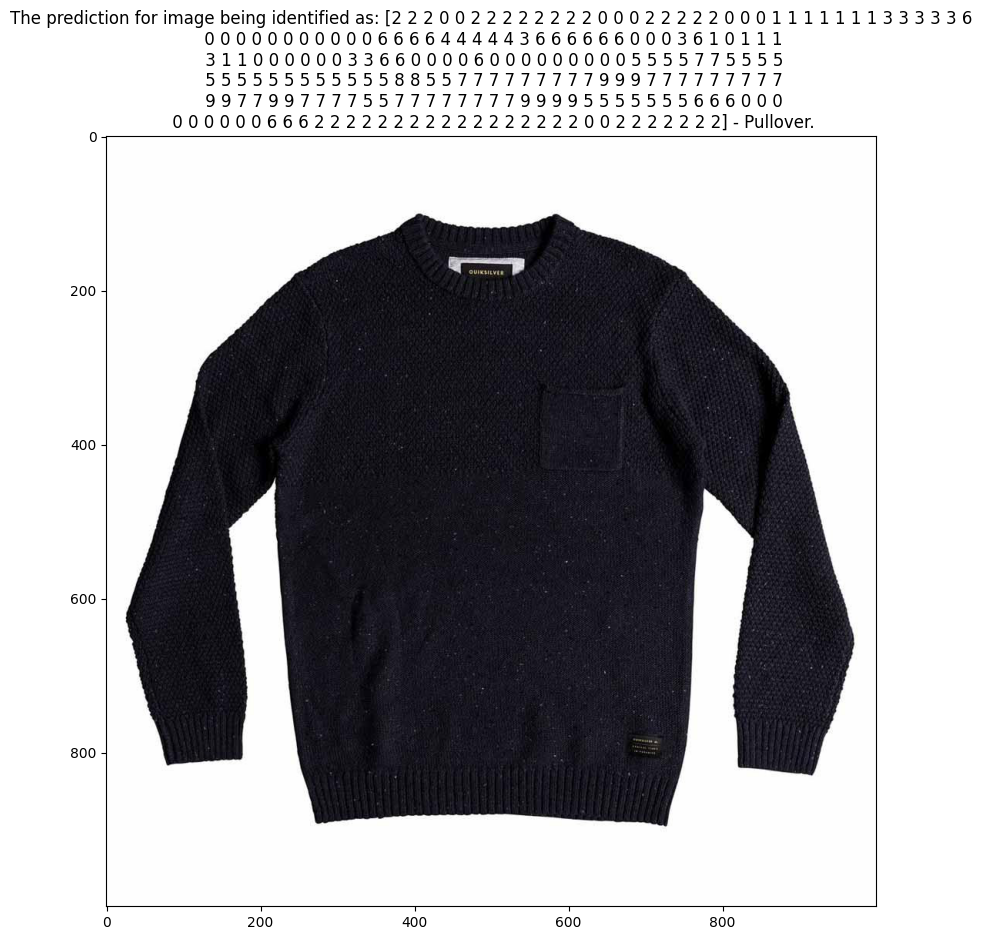

In [93]:
check("/content/sweatshirt.jpg", "/content/sweatshirt2.jpg")